In [1]:
!pip install CoolProp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Thermo-thesis/')

In [4]:
from sCO2Utils import *
from config import Config

In [5]:
def resolve_REC_cycle(
    P1 : float,
    T1 : float,
    T6 : float,
    pump_isentropic_efficiency : float,
    turbine_isentropic_efficiency : float,
    heat_exchanger_efficiency : float,
    rp : float,
    grading : float,
    y : float
):
  max_iterations = 100 # Iterations for the feedback loop
  P7,P8,P9 = P1,P1,P1
  P2 = P1*rp
  P3,P4,P4a,P5,P6 = P2,P2,P2,P2,P2

  ################ Compute known states #################
  state1 = ThermodynamicState(p = P1,t = T1) ; state1.compute_from_p_t()
  state6 = ThermodynamicState(p = P6,t = T6) ; state6.compute_from_p_t()
  ################# INITIALIZING THE TURBINE AND PUMP #######################
  turbine = Turbine(isentropic_efficiency=turbine_isentropic_efficiency,output_pressure=P7)
  pump = Pump(isentropic_efficiency=pump_isentropic_efficiency, output_pressure=P2) # The 2 pumps are identical
  ############################################
  ######## RESOLVING AFTER PUMP STATE ###############
  state2 = pump.resolve_actual_output_state(input_state = state1)
  # CALCULATING THE WORK REQUIRED BY THE PUMP
  w_pump_1 = (state2.h - state1.h)*(1-y) # take into account the flow is split

  #print(f'Pump 1 used up {"{:.2f}".format(w_pump_1)} KJ/kg of work')

  ############# RESOLVING AFTER TURBINE STATE ##############
  state7 = turbine.resolve_actual_output_state(input_state = state6)
  # CALCULTAING THE WORK DONE BY THE TURBINE
  w_turbine_out = state6.h - state7.h

  #print(f'The turbine produced {"{:.2f}".format(w_turbine_out)} KJ/kg of work')

  ####### THIS MEANS THAT THE OTHER PUMP CAN AT MAXIMUM USE w_turbine_out - w_pump_1*recompression_ratio amount of KJ/kg

  #print(f'There is only {w_turbine_out - w_pump_1} KJ/kg left for the other pump')

  ################################################################################
  # Initial guess for H8
  H8_estimate = PropsSI('H','T',(state2.t+state7.t)/2, 'P',P7,'CO2')/1000 # Convert toKJ/kg
  H8 = 100 # Initial dummy value
  try:
    cnt = 0
    while np.absolute(H8_estimate - H8) > .01:

      state8 = ThermodynamicState(p = P8,h = H8_estimate) ; state8.compute_from_p_h()

      LTR_heat_exchanger = HeatExchanger(
            stream1_entry_state=state2,
            stream2_entry_state=state8,
            stream1_mass_flow_rate=1-y,
            grading = grading,
            efficiency = heat_exchanger_efficiency
        )


      state3, state9 = LTR_heat_exchanger.resolve_exit_states()
      state4 = pump.resolve_actual_output_state(input_state = state9)

      # Now mixing happens
      state4a = ThermodynamicState(p = P4,h = (1-y)*state3.h + y*state4.h)
      state4a.compute_from_p_h()

      HTR_heat_exchanger = HeatExchanger(
            stream1_entry_state=state4a,
            stream2_entry_state=state7,
            grading =grading,
            efficiency = heat_exchanger_efficiency
        )

      state5,state8 = HTR_heat_exchanger.resolve_exit_states()

      if cnt < max_iterations: # MAX iterations

        H8 = H8_estimate # PREVIOUS ESTIMATE
        H8_estimate = state8.h # NEW ESTIMATE
        cnt+=1
      else:
        print('Convergence failed')
        break
  except Exception as e:
    print(e)
    print(state9.to_dict())



  qout = np.absolute((state9.h -state1.h)*(1-y))
  qin = state6.h - state5.h
  # Aternatively the cycle efficiency is W_net/q_in , where w_net = w_turb_out - w_pump_in
  # eta_rankine = 1 - qout/qin # Compute Efficiency
  w_pump_2 = (state4.h - state9.h)*y
  #print(f'The second pumped used up {"{:.2f}".format(w_pump_2)} KJ/kg of work')
  w_net = w_turbine_out - (w_pump_1 + w_pump_2) # Take into account the flow is split

  eta = w_net/qin
  #eta = 1-qout/qin
  #print(f'The heat balance is {qin-qout} and the W net is {w_net} and q_in is {qin}')
  #print(f'Efficiency based on heat is {1-qout/qin}')

  return [eta, [state1,state2,state3,state4,state4a,state5,state6,state7,state8,state9]]

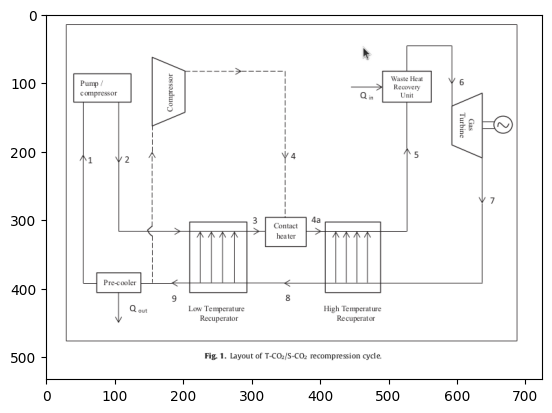

In [6]:
img = plt.imread('REC_design_2.png')
plt.imshow(img)

New parameters to study is mass recompression ratio

We know by conservation of energy and conservation of mass in the Mixer the following is true:

$\dot{m_3} + \dot{m_4} = \dot{m_{4a}}$

$\dot{m_3} h_3 + \dot{m_4} h_4 = \dot{m_{4a}}h_{4a}$, divide by $\dot{m_{4a}}$ results in

$(1-y)h_3 + yh_4 = h_{4a}$, where $y$ is called the mass recompression ratio, which we can choose

$0 < y < 1$

SANITY CHECK

for y = 0 and heat_exchanger_efficiency = 0 we have a simple Rankine cycle

We know that for rp = 4.126 we reach the maximum efficiency of 14.32%

In [7]:
# INITIAL CONDITIONS
P1 = Config.rankine_Pmin
T1 = Config.T1
T6 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = 0

In [8]:
# CROSS CHECK WITH PAPER RESULTS - Table 5 Banik
_eta, states_list = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = 4.126,
        y = .0000001,
        grading = 1
    )
_l = [state.to_dict() for state in states_list]
df = pd.DataFrame(_l)
df.index = ['1','2','3','4','4a','5','6','7','8','9']
print(df)

    pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1       7190000.0       303.000000        302.929951          1.338232
2      29665940.0       349.018801        342.542713          1.361058
3      29665940.0       349.018801        342.542713          1.361058
4      29665940.0       500.072914        610.753297          2.007667
4a     29665940.0       349.018814        342.542739          1.361058
5      29665940.0       349.018814        342.542739          1.361058
6      29665940.0       473.000000        570.742338          1.925387
7       7190000.0       352.457497        498.455899          1.962045
8       7190000.0       352.457497        498.455899          1.962045
9       7190000.0       352.457497        498.455899          1.962045


In [9]:
# The resulting efficiency is
_eta

0.14318022677523945

There is no difference to the known result!

Let us check REC design when recompression mass ratio is 0. This is the REG design

We know that for rp = 3.24 we reach an efficiency of 15.05%

In [10]:
# INITIAL CONDITIONS
P1 = Config.rankine_Pmin
T1 = Config.T1
T6 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

In [11]:
# CROSS CHECK WITH PAPER RESULTS - Table 5 Banik
_eta, states_list = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = 3.24,
        y = .00001,
        grading = 1
    )
_l = [state.to_dict() for state in states_list]
df = pd.DataFrame(_l)
df.index = ['1','2','3','4','4a','5','6','7','8','9']
print(df)

    pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1       7190000.0       303.000000        302.929951          1.338232
2      23295600.0       339.491682        332.101993          1.355482
3      23295600.0       345.088223        345.093253          1.393437
4      23295600.0       466.549359        578.106210          1.979981
4a     23295600.0       345.089220        345.095583          1.393443
5      23295600.0       353.071503        363.841249          1.447145
6      23295600.0       473.000000        587.496006          1.999970
7       7190000.0       371.076890        523.331722          2.030849
8       7190000.0       356.884973        504.586055          1.979330
9       7190000.0       347.641694        491.586785          1.942421


In [12]:
_eta

0.15645394623186448

We are now using Wnet, instead of qout to calculate efficiency. The difference of .6 % in efficiency is caused by loss of accuracy by use of 2 heat exchangers

# Onto the study of the REC design by varying both rp and recompression mass ratio

In [13]:
# INITIAL CONDITIONS
P1 = Config.rankine_Pmin
T1 = Config.T1
T6 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

In [14]:
rp_min = Config.rankine_rp_min
rp_max = Config.rankine_rp_max
N = 20 # points
M = 20 # points
rp_list = list(np.linspace(rp_min,rp_max,N))
y_list = list(np.linspace(0.01,.6,M))
REC_efficiency = np.zeros((N,M))

for rp_id, rp in enumerate(list(rp_list)):
  for y_id, y in enumerate(y_list):
    REC_efficiency[rp_id, y_id] = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp,
        y = y,
        grading = 1
    )[0]

In [15]:
# PAY ATTENTION
# PLOTLY SWAPS THE X, Y axes of a np.array when it plots
fig = go.Figure(data=[go.Surface(x = y_list, y = rp_list,z=np.clip(REC_efficiency, a_min=0, a_max = 1))])
# This is why x = y_list, instead of rp_list
fig.update_layout(title='Rankine efficiency vs pressure ratio REC design')
fig.update_scenes(zaxis_title_text='Efficiency ',
                  yaxis_title_text= 'Pressure ratio',
                  xaxis_title_text= 'Mass recompression ratio')
fig.show()

In [16]:
rp_best_idx, y_best_idx = np.where(REC_efficiency == REC_efficiency.max())
rp_best = rp_list[rp_best_idx[0]]
y_best = y_list[y_best_idx[0]]
print(f'The maximum of efficiency of {"{:.2f}".format(REC_efficiency.max()*100)} % is reached for rp = {rp_best} and recompression mass ratio {y_best}')

The maximum of efficiency of 15.67 % is reached for rp = 2.863157894736842 and recompression mass ratio 0.01


Essentially what this result tells us is that the REG design is superior to REC and recompression is not advantageous

In [17]:
_eta, states_list = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp_best,
        y = y_best,
        grading = 1
    )

In [18]:
_l = [state.to_dict() for state in states_list]
df = pd.DataFrame(_l)
df.index = ['1','2','3','4','4a','5','6','7','8','9']
print(df)

    pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1    7.190000e+06       303.000000        302.929951          1.338232
2    2.058611e+07       334.981282        327.531527          1.352965
3    2.058611e+07       342.650327        346.751991          1.409692
4    2.058611e+07       451.384719        564.684716          1.970269
4a   2.058611e+07       343.507975        348.931318          1.416045
5    2.058611e+07       354.323358        376.602281          1.495356
6    2.058611e+07       473.000000        595.723612          2.037452
7    7.190000e+06       381.354713        536.278822          2.065267
8    7.190000e+06       359.850997        508.607859          1.990552
9    7.190000e+06       346.260213        489.571715          1.936613


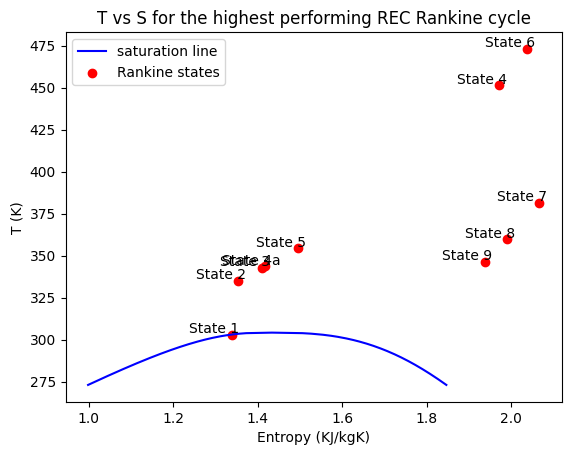

In [19]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing REC Rankine cycle')
state_xpoints = [state.s for state in states_list]
state_ypoints = [state.t for state in states_list]
ax.text(state_xpoints[0] - .1, state_ypoints[0] + 1,'State 1')
ax.text(state_xpoints[1] - .1, state_ypoints[1] + 1,'State 2')
ax.text(state_xpoints[2] - .1, state_ypoints[2] + 1,'State 3')
ax.text(state_xpoints[3] - .1, state_ypoints[3] + 1,'State 4')
ax.text(state_xpoints[4] - .1, state_ypoints[4] + 1,'State 4a')
ax.text(state_xpoints[5] - .1, state_ypoints[5] + 1,'State 5')
ax.text(state_xpoints[6] - .1, state_ypoints[6] + 1,'State 6')
ax.text(state_xpoints[7] - .1, state_ypoints[7] + 1,'State 7')
ax.text(state_xpoints[8] - .1, state_ypoints[8] + 1,'State 8')
ax.text(state_xpoints[9] - .1, state_ypoints[9] + 1,'State 9')
ax.scatter(state_xpoints, state_ypoints, color = 'red', label = 'Rankine states')
ax.legend()

# SANITY CHECK WITH BANIK Paper results

In [27]:
# INITIAL CONDITIONS
P1 = 5e6
T1 = 287.43
T6 = 273+170
pump_isentropic_efficiency = .85
turbine_isentropic_efficiency = .85
heat_exchanger_efficiency = .85

In [28]:
rp_min = 1.5
rp_max = 7
N = 10 # points
M = 10 # points
rp_list = list(np.linspace(rp_min,rp_max,N))
y_list = list(np.linspace(0.01,.6,M))
REC_efficiency = np.zeros((N,M))

for rp_id, rp in enumerate(list(rp_list)):
  for y_id, y in enumerate(y_list):
    REC_efficiency[rp_id, y_id] = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp,
        y = y,
        grading = 1
    )[0]

Convergence failed
Convergence failed
Convergence failed


In [29]:
fig = go.Figure(data=[go.Surface(z=np.clip(REC_efficiency, a_min=0, a_max = 1), y = rp_list, x = y_list)])
fig.update_layout(title='Rankine efficiency vs pressure ratio REC design')
fig.update_scenes(zaxis_title_text='Efficiency ',
                  yaxis_title_text='Pressure ratio',
                  xaxis_title_text='Mass recompression ratio')
fig.show()

In [30]:
rp_best, y_best = np.where(REC_efficiency == REC_efficiency.max())
rp_best = rp_best[0]
y_best = y_best[0]
print(f'The maximum of efficiency of {"{:.2f}".format(REC_efficiency.max()*100)} % is reached for rp = {rp_best} and recompression mass ratio {y_best}')

The maximum of efficiency of 16.53 % is reached for rp = 4 and recompression mass ratio 0


Our results are contrasting with Banik's results

The process of recompression seems to not be advantageous at all

In [31]:
_eta, states_list = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp_best,
        y = y_best,
        grading = 1
    )

In [32]:
_l = [state.to_dict() for state in states_list]
df = pd.DataFrame(_l)
df.index = ['1','2','3','4','4a','5','6','7','8','9']
print(df)

    pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1       5000000.0       287.430000        237.852906          1.128819
2      20000000.0       304.691309        258.330430          1.138924
3      20000000.0       309.352894        268.541680          1.172182
4      20000000.0       439.861047        549.579499          1.940817
4a     20000000.0       309.352894        268.541680          1.172182
5      20000000.0       315.591432        282.558341          1.217039
6      20000000.0       443.000000        554.339315          1.951600
7       5000000.0       328.869217        488.705601          1.987297
8       5000000.0       318.433342        474.688940          1.943977
9       5000000.0       311.360233        464.469149          1.911516


In [33]:
# CROSS CHECK WITH PAPER RESULTS - Table 5 Banik
_eta, states_list = resolve_REC_cycle(
        P1 = 5e6,
        T1 = 287.43,
        T6 = 443,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = 2.4,
        y = .4,
        grading = 1
    )
_l = [state.to_dict() for state in states_list]
df = pd.DataFrame(_l)
df.index = ['1','2','3','4','4a','5','6','7','8','9']
print(df)

    pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1       5000000.0       287.430000        237.852906          1.128819
2      12000000.0       296.302994        247.591044          1.133754
3      12000000.0       315.209194        303.340622          1.315799
4      12000000.0       402.631526        533.581825          1.979527
4a     12000000.0       335.731142        395.437103          1.598654
5      12000000.0       343.180407        421.286876          1.674846
6      12000000.0       443.000000        587.664776          2.107655
7       5000000.0       370.796634        538.888896          2.131108
8       5000000.0       348.508725        513.039123          2.059192
9       5000000.0       321.990689        479.585582          1.959269


In [34]:
_eta

0.12822917218670335

REPRODUCE FIGURE 7 FROM BANIK

In [35]:
# Reproduce Fig 7 Banik
y_list = [.3,.4,.5,.6]
effs_24 = np.zeros(4)
effs_20 = np.zeros(4)
for idx, y in enumerate(y_list):
  effs_24[idx] = resolve_REC_cycle(
          P1 = 5e6,
          T1 = 287.43,
          T6 = 443,
          pump_isentropic_efficiency=pump_isentropic_efficiency,
          turbine_isentropic_efficiency=turbine_isentropic_efficiency,
          heat_exchanger_efficiency= heat_exchanger_efficiency,
          rp = 2.4,
          y = y,
          grading = 1
      )[0]

  effs_20[idx] = resolve_REC_cycle(
          P1 = 5e6,
          T1 = 287.43,
          T6 = 443,
          pump_isentropic_efficiency=pump_isentropic_efficiency,
          turbine_isentropic_efficiency=turbine_isentropic_efficiency,
          heat_exchanger_efficiency= heat_exchanger_efficiency,
          rp = 2,
          y = y,
          grading = 1
      )[0]



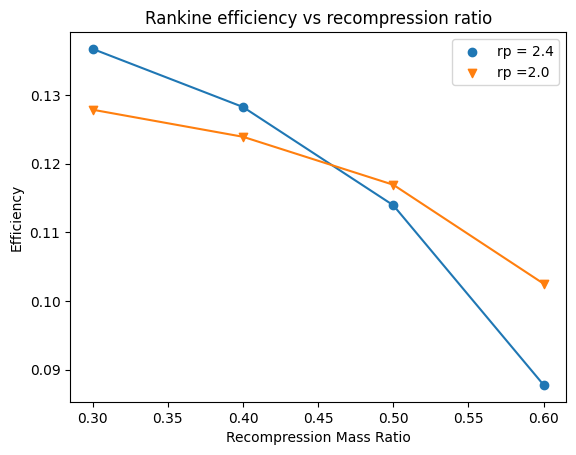

In [36]:
fig, ax = plt.subplots(1,1)
ax.scatter(y_list,effs_24, marker = 'o', label = 'rp = 2.4')
ax.plot(y_list,effs_24)
ax.scatter(y_list,effs_20, marker = 'v', label = 'rp =2.0')
ax.plot(y_list,effs_20)
ax.set_title('Rankine efficiency vs recompression ratio')
ax.set_xlabel('Recompression Mass Ratio')
ax.set_ylabel('Efficiency')
ax.legend()
# This plot is generated for P1 = 5MPa

The difference from Banik paper may arrise because of the way we treat the Heat Exchanger.

In their paper, they consider the two fluids to essentially exchange temperatures, just as for an ideal heat exchanger where the fluid properties are identical in the two streams.

# CHECK BRAYTON

In [20]:
# INITIAL CONDITIONS
P1 = Config.brayton_Pmin
T1 = Config.T1
T6 = Config.Tmax
rp_min = Config.brayton_rp_min
rp_max = Config.brayton_rp_max
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

In [21]:
N = 10 # points
M = 10 # points
rp_list = list(np.linspace(rp_min,rp_max,N))
y_list = list(np.linspace(0.01,.6,M))
REC_efficiency = np.zeros((N,M))

for rp_id, rp in enumerate(list(rp_list)):
  for y_id, y in enumerate(y_list):
    REC_efficiency[rp_id, y_id] = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp,
        y = y,
        grading = 1
    )[0]

In [22]:
# PAY ATTENTION
# PLOTLY SWAPS THE X, Y axes of a np.array when it plots
fig = go.Figure(data=[go.Surface(x = y_list, y = rp_list,z=np.clip(REC_efficiency, a_min=0, a_max = 1))])
# This is why x = y_list, instead of rp_list
fig.update_layout(title='Brayton efficiency vs pressure ratio REC design')
fig.update_scenes(zaxis_title_text='Efficiency ',
                  yaxis_title_text= 'Pressure ratio',
                  xaxis_title_text= 'Mass recompression ratio')
fig.show()

In [23]:
rp_best_idx, y_best_idx = np.where(REC_efficiency == REC_efficiency.max())
rp_best = rp_list[rp_best_idx[0]]
y_best = y_list[y_best_idx[0]]
print(f'The maximum of efficiency of {"{:.2f}".format(REC_efficiency.max()*100)} % is reached for rp = {rp_best} and recompression mass ratio {y_best}')

The maximum of efficiency of 15.41 % is reached for rp = 2.908888888888889 and recompression mass ratio 0.01


In [24]:
_eta, brayton_states_list = resolve_REC_cycle(
        P1 = P1,
        T1 = T1,
        T6 = T6,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp_best,
        y = y_best,
        grading = 1
    )

In [25]:
_l = [state.to_dict() for state in brayton_states_list]
df = pd.DataFrame(_l)
df.index = ['1','2','3','4','4a','5','6','7','8','9']
print(df)

    pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1    7.500000e+06       303.000000        290.458448          1.295477
2    2.181667e+07       330.877769        315.003583          1.310361
3    2.181667e+07       339.836644        336.254395          1.373728
4    2.181667e+07       449.020780        556.774783          1.943690
4a   2.181667e+07       340.750366        338.459599          1.380208
5    2.181667e+07       352.471591        367.122324          1.462906
6    2.181667e+07       473.000000        591.911589          2.019946
7    7.500000e+06       379.835895        532.232144          2.047979
8    7.500000e+06       358.143824        503.569419          1.970241
9    7.500000e+06       343.764859        482.528911          1.910259


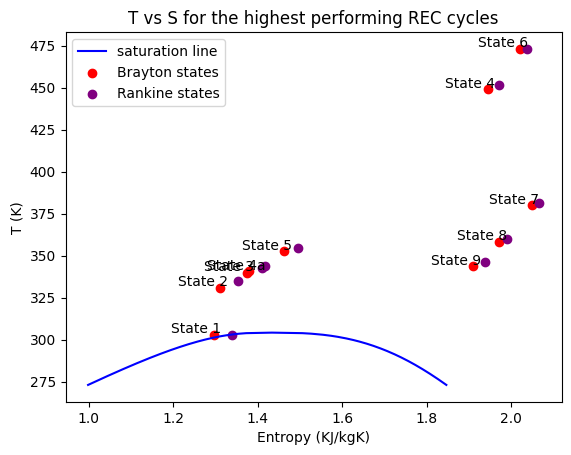

In [26]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing REC cycles')
brayton_state_xpoints = [state.s for state in brayton_states_list]
brayton_state_ypoints = [state.t for state in brayton_states_list]
ax.text(brayton_state_xpoints[0] - .1, brayton_state_ypoints[0] + 1,'State 1')
ax.text(brayton_state_xpoints[1] - .1, brayton_state_ypoints[1] + 1,'State 2')
ax.text(brayton_state_xpoints[2] - .1, brayton_state_ypoints[2] + 1,'State 3')
ax.text(brayton_state_xpoints[3] - .1, brayton_state_ypoints[3] + 1,'State 4')
ax.text(brayton_state_xpoints[4] - .1, brayton_state_ypoints[4] + 1,'State 4a')
ax.text(brayton_state_xpoints[5] - .1, brayton_state_ypoints[5] + 1,'State 5')
ax.text(brayton_state_xpoints[6] - .1, brayton_state_ypoints[6] + 1,'State 6')
ax.text(brayton_state_xpoints[7] - .1, brayton_state_ypoints[7] + 1,'State 7')
ax.text(brayton_state_xpoints[8] - .1, brayton_state_ypoints[8] + 1,'State 8')
ax.text(brayton_state_xpoints[9] - .1, brayton_state_ypoints[9] + 1,'State 9')
ax.scatter(brayton_state_xpoints, brayton_state_ypoints, color = 'red', label = 'Brayton states')
ax.scatter(state_xpoints, state_ypoints, color = 'purple', label = 'Rankine states')
ax.legend()